In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# For nice Plots
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [2]:
# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.datasets import load_iris
iris = load_iris()
print("Iris data shape (# Observations, # Features): "+str(iris.data.shape))
print("Iris data features: "+str(iris.feature_names))
print("Iris data class labels: "+str(iris.target_names))
#print(iris.DESCR)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
  iris.data, iris.target, test_size=0.33)
print("------------")

from sklearn.datasets import load_digits
digits = load_digits()
print("Digits data shape (# Observations, # Features): "+str(digits.data.shape))
#print("Digits data features: "+str(digits.feature_names))
print("Digits data class labels: "+str(digits.target_names))
#print(digits.DESCR)
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
  digits.data, digits.target, test_size=0.33)

Iris data shape (# Observations, # Features): (150, 4)
Iris data features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris data class labels: ['setosa' 'versicolor' 'virginica']
------------
Digits data shape (# Observations, # Features): (1797, 64)
Digits data class labels: [0 1 2 3 4 5 6 7 8 9]


# K-Nearest Neighbors

In [3]:
X_train, X_test, y_train, y_test = X_train_iris, X_test_iris, y_train_iris, y_test_iris
target_names = iris.target_names
#X_train, X_test, y_train, y_test = X_train_digits, X_test_digits, y_train_digits, y_test_digits
#target_names = str(digits.target_names)

In [4]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
yhat_knn = knn.predict(X_test)
acc_knn = np.sum(yhat_knn == y_test)/len(y_test)
print("Knn Accuracy: "+str(acc_knn))

Knn Accuracy: 0.94


## Evaluation Metrics

In [5]:
print(classification_report(y_test, yhat_knn, target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.89      0.94      0.91        17
   virginica       0.94      0.88      0.91        17

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



[[16  0  0]
 [ 0 16  1]
 [ 0  2 15]]


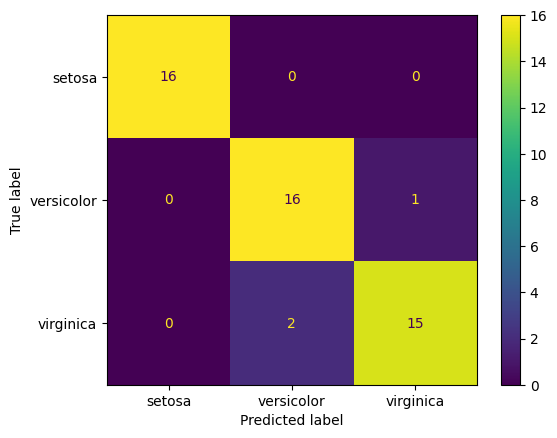

In [6]:
cm = confusion_matrix(y_test, yhat_knn)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot();

## Cross-Validation

In [7]:
# compute the cross validation accuracy:
acc_cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
print(acc_cv_scores)
print("%0.2f mean accuracy with a standard deviation of %0.2f" % (acc_cv_scores.mean(), acc_cv_scores.std()))
# compute the cross validation F1 score:
f1_cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
print(f1_cv_scores)
print("%0.2f mean F1 with a standard deviation of %0.2f" % (acc_cv_scores.mean(), acc_cv_scores.std()))

[1.  0.9 1.  1.  1.  1.  1.  0.9 1.  0.9]
0.97 mean accuracy with a standard deviation of 0.05
[0.94747475 1.         1.         1.         0.90277778]
0.97 mean F1 with a standard deviation of 0.05


In [8]:
# Use cross validation to select a good value for k
acc_test = np.zeros(49)
acc_train = np.zeros(49)
acc_cv = np.zeros(49)
for k in range(1,50):
  knn = KNeighborsClassifier(n_neighbors=k)
  acc_cv[k-1] = cross_val_score(knn, X_train, y_train, cv=10).mean()
  # Train 
  knn.fit(X_train, y_train)
  # Apply to Validatio/Test Data
  yhat_knn = knn.predict(X_test)
  acc_test[k-1] = np.sum(yhat_knn == y_test)/len(y_test)
  # Apply to Validatio/Test Data
  yhat_knn = knn.predict(X_train)
  acc_train[k-1] = np.sum(yhat_knn == y_train)/len(y_train)

# find the (a) best k value
k_max = np.argmax(acc_cv)+1


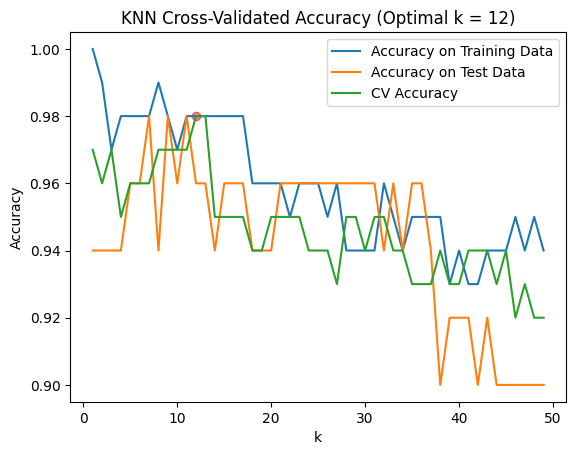

In [9]:
plt.plot(np.linspace(1,49, num=49),acc_train, label='Accuracy on Training Data')
plt.plot(np.linspace(1,49, num=49),acc_test, label='Accuracy on Test Data')
plt.plot(np.linspace(1,49, num=49),acc_cv, label='CV Accuracy')
plt.scatter(k_max,acc_cv[k_max-1], c='r', alpha=0.5)
plt.legend()
plt.xlabel('k');
plt.ylabel('Accuracy');
plt.title("KNN Cross-Validated Accuracy (Optimal k = "+str(k_max)+")");

Some good thoughts on cross-validation: https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation

- A Single test-train splie is like 2-fold cross validation.  The two models may be independent (their training sets do not overlap, ideally using independent samples), but the size of the training and testing sets may be too small.

- Leave-One-Out-Cross-Validation makes N = (# Observations) models, but they are often highly correlated.

- $\Rightarrow $ Usually a 5 or 10 fold cross validation is a safe middle ground for best results.

## Repeated \ Monte Carlo Training and Validation

In [10]:
acc_test = np.zeros(49)
acc_train = np.zeros(49)
acc_cv = np.zeros(49)

In [11]:
N = 100
for i in range(N):
  X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.33)
  for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k)
    acc_cv[k-1] = acc_cv[k-1] + cross_val_score(knn, X_train, y_train, cv=10).mean()
    # Train 
    knn.fit(X_train, y_train)
    # Apply to Validatio/Test Data
    yhat_knn = knn.predict(X_test)
    acc_test[k-1] = acc_test[k-1] + np.sum(yhat_knn == y_test)/len(y_test)
    # Apply to Validatio/Test Data
    yhat_knn = knn.predict(X_train)
    acc_train[k-1] = acc_train[k-1] + np.sum(yhat_knn == y_train)/len(y_train)

# find the (a) best k value
acc_cv = acc_cv/N
acc_test = acc_test/N
acc_train = acc_train/N
k_max = np.argmax(acc_cv)+1

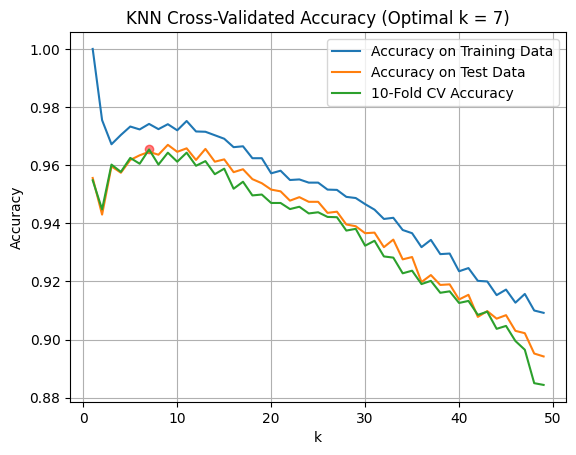

In [12]:
plt.plot(np.linspace(1,49, num=49),acc_train, label='Accuracy on Training Data')
plt.plot(np.linspace(1,49, num=49),acc_test, label='Accuracy on Test Data')
plt.plot(np.linspace(1,49, num=49),acc_cv, label='10-Fold CV Accuracy')
plt.scatter(k_max,acc_cv[k_max-1], c='r', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('k');
plt.ylabel('Accuracy');
plt.title("KNN Cross-Validated Accuracy (Optimal k = "+str(k_max)+")");

## Visualization

In [13]:
data, labels = iris.data, iris.target
data.shape

(150, 4)

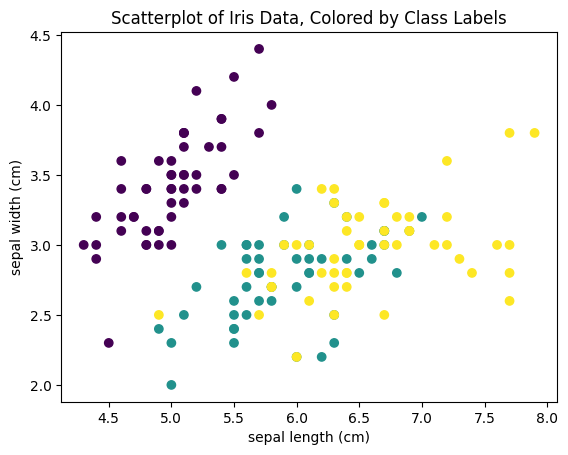

In [14]:
plt.scatter(data[:,0], data[:,1], c=labels)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Scatterplot of Iris Data, Colored by Class Labels');

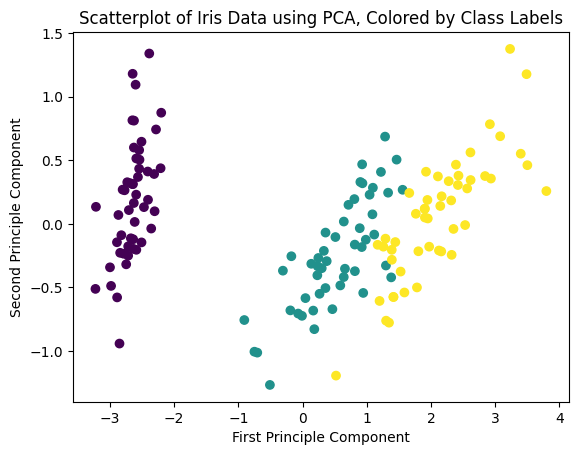

In [15]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# plot the data
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.title('Scatterplot of Iris Data using PCA, Colored by Class Labels');

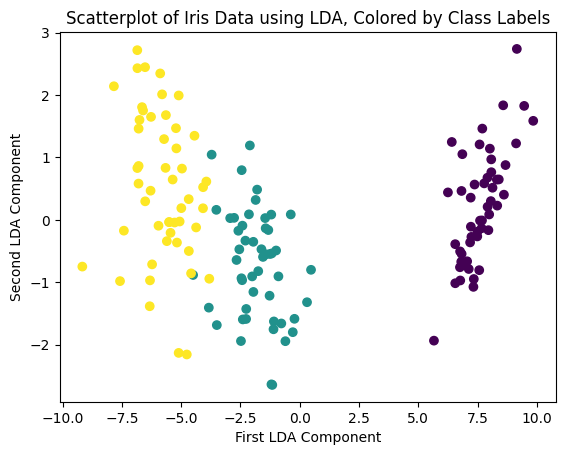

In [16]:
lda = LDA(n_components=2)
data_lda = lda.fit_transform(data, labels)

# plot the data
plt.scatter(data_lda[:, 0], data_lda[:, 1], c=labels)
plt.xlabel('First LDA Component')
plt.ylabel('Second LDA Component')
plt.title('Scatterplot of Iris Data using LDA, Colored by Class Labels');